# Preamble

In [1]:
!date

Thu Nov 14 03:11:33 PST 2024


In [2]:
%load_ext autoreload
%load_ext line_profiler

In [3]:
import logging

logging.basicConfig(level=logging.INFO, force=True)

In [4]:
import os as _os

_os.chdir(_os.environ["PROJECT_ROOT"])

In [5]:
import os
from contextlib import contextmanager
from itertools import chain, product
from multiprocessing import Pool

import fastcluster
import graph_tool as gt
import graph_tool.draw
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import strainzip as sz
import strainzip.app.unzip
import xarray as xr
from graph_tool.util import find_edge
from scipy.cluster.hierarchy import fcluster, linkage
from strainzip.pandas_util import idxwhere
from tqdm import tqdm

import lib.plot

# Params

## Plotting

In [6]:
mpl.rcParams["figure.dpi"] = 100
# sns.set_context('talk')

In [7]:
# Plotting parameters

length_bins = np.logspace(0, 6.5, num=51)
depth_bins = np.logspace(-1, 4, num=51)

draw_graphs = True

## Which assembly / output dir

In [8]:
k = 111
group = "btheta_2strains_tiles_k111"
graph_type = f"k{k}-denovo0-droptips"
smoothing = "smoothed-6"
deconv = "norm-nobal-10-10"
clust_params = "e50-n20000-d20"

fig_dir = f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.figs.d"
try:
    os.mkdir(fig_dir)
except FileExistsError:
    pass

# Load data / Summarize stats

## Metadata

In [9]:
# Metadata
sample_idx_to_id = (
    pd.read_table("meta/mgen_group.tsv", names=["mgen_id", "mgen_group"])[
        lambda x: x.mgen_group == group
    ]
    .mgen_id.to_frame()
    .assign(idx=lambda x: range(len(x)))
    .set_index("idx")
    .mgen_id
)
sample_idx_to_id

# NOTE: This only applies to xjin samples:
# sample_idx_to_id = sample_idx_to_id.str.split('_', n=1).str[1]
sample_idx_to_id  # .head()

idx
0    Bacteroides-thetaiotaomicron-1-1-6_MAF-2_tiles...
1    Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_ti...
Name: mgen_id, dtype: object

In [10]:
clust_meta = pd.read_table(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.clust-{clust_params}.meta.tsv",
    index_col="cluster",
)
vertex_to_clust = pd.read_table(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.clust-{clust_params}.vertex.tsv",
    index_col="vertex",
).cluster
segement_x_clust = pd.read_table(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.clust-{clust_params}.segment.tsv",
    index_col="segment",
).cluster
print(len(clust_meta))
clust_meta.sort_values("total_length", ascending=False).head(20)

7


,num_vertices,num_segments,num_unique_segments,total_length,total_depth
cluster,,,,,
5,164,30427,27576,13802781,1.830991
1,346,28673,27854,13655694,1.999177
4,4,1414,1414,382250,0.209783
0,5,170,149,38473,0.739585
6,66,97,96,17113,10.440259
3,6,45,45,6068,9.193717
2,9,17,17,1450,7.461209


## Graphs

In [11]:
%%time

unpressed_graph = sz.io.load_graph(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2-unpressed.sz"
)
unpressed_results = sz.results.extract_vertex_data(unpressed_graph)
print(
    (unpressed_results.length * unpressed_results.total_depth).sum()
    / unpressed_results.total_depth.sum()
)

obs_segment_depth = sz.results.extract_segment_depth(unpressed_graph)

456.822295667009
CPU times: user 1.06 s, sys: 48 ms, total: 1.11 s
Wall time: 1.11 s


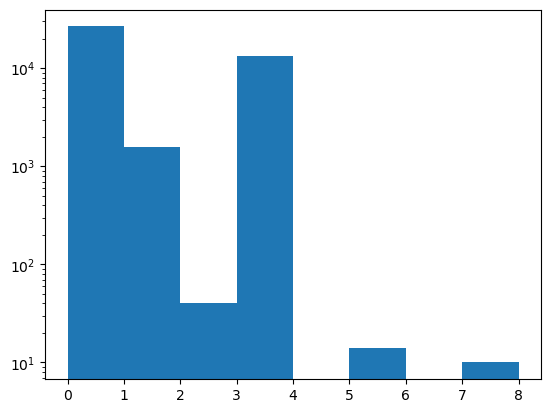

In [12]:
segment_length = (
    unpressed_results.assign(segment=lambda x: x.segments.str[0])
    .set_index("segment")
    .length
)
# For each segment how many extra paths could have gone through it? max((N * M) - 1, 0)
segment_complexity = pd.Series(
    (unpressed_results.num_in_neighbors * unpressed_results.num_out_neighbors - 1)
    .where(lambda x: x > 0, 0)
    .values,
    index=unpressed_results.segments.str[0],
)
squared_segment_complexity = np.square(segment_complexity)

plt.hist(segment_complexity, bins=np.arange(segment_complexity.max() + 1))
plt.yscale("log")

In [13]:
%%time
final_graph = sz.io.load_graph(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.sz"
)
final_results = sz.results.extract_vertex_data(final_graph)
ss_vertex_complexity = (
    final_results.segments.explode()
    .to_frame("segment")
    .reset_index()
    .join(squared_segment_complexity.rename("segment_complexity"), on="segment")
    .drop_duplicates()
    .groupby("vertex")
    .segment_complexity.sum()
)
vertex_complexity = np.sqrt(ss_vertex_complexity)

final_results = final_results.assign(
    complexity=vertex_complexity,
    clust=vertex_to_clust.reindex(final_results.index, fill_value=-1),
)

vertex_depth = sz.results.depth_table(final_graph, final_graph.get_vertices()).T
vertex_length = pd.Series(final_graph.vp["length"], index=final_graph.get_vertices())

CPU times: user 37.5 ms, sys: 7.89 ms, total: 45.4 ms
Wall time: 44.7 ms


          orf gene_name  bitscore  vertex
0      214_59      rpoB    1861.3     214
1      297_59      rpoB    1861.3     297
2  528_511_33      rpoB    1861.3     528


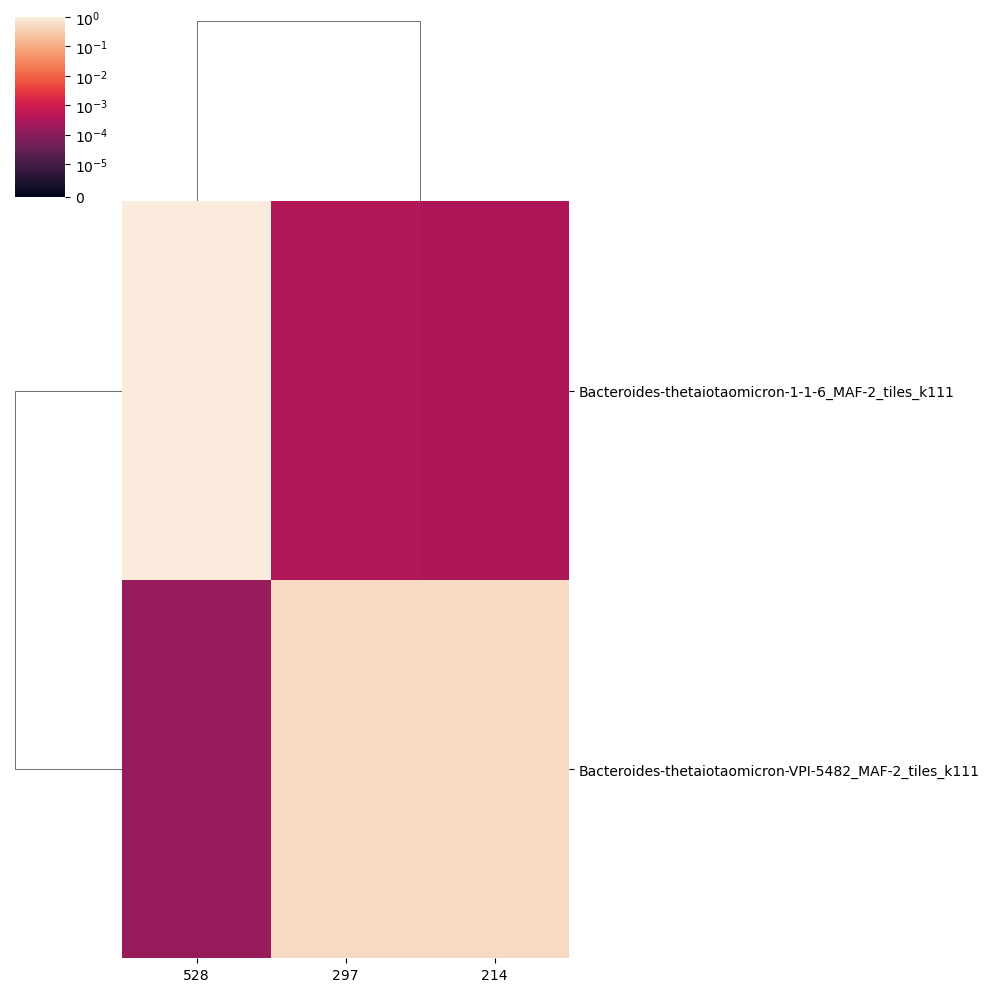

In [14]:
# Normalize by rpoB and gyrA depth

marker_model = "TIGR02013"

marker_genes = pd.read_table(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.cds.tran.hmmer-{marker_model}-ga.tsv",
    names=["orf", "gene_name", "bitscore"],
).assign(vertex=lambda x: x.orf.str.split("_").str[0].astype(int))
_marker_gene_vertex_list = list(set(marker_genes.vertex))
marker_depth = vertex_depth.loc[_marker_gene_vertex_list].T
total_marker_depth = marker_depth.sum(1)

print(marker_genes)

normalized_vertex_depth = vertex_depth.divide(total_marker_depth)

marker_rabund = marker_depth.divide(total_marker_depth, axis=0)
# plt.hist(marker_depth.sum())
sns.clustermap(
    marker_rabund.rename(sample_idx_to_id) + 1e-5,
    norm=mpl.colors.SymLogNorm(1e-5, vmin=0, vmax=1),
    metric="cosine",
)

In [15]:
%%time

print(
    (final_results.length * final_results.total_depth).sum()
    / final_results.total_depth.sum()
)
final_segment_depth = sz.results.extract_segment_depth(final_graph)

24247.534112055968
CPU times: user 47.7 ms, sys: 2.17 ms, total: 49.9 ms
Wall time: 49.3 ms


In [16]:
# Used below for visualizing the graph
# This part is slow enough that it's better to cache it and pass it to the get_shortest_distance function.
backlinked_unpressed_graph = sz.topology.backlinked_graph(unpressed_graph)

PearsonRResult(statistic=0.9928343835897561, pvalue=0.0)
CPU times: user 54.1 ms, sys: 42 µs, total: 54.1 ms
Wall time: 53.5 ms


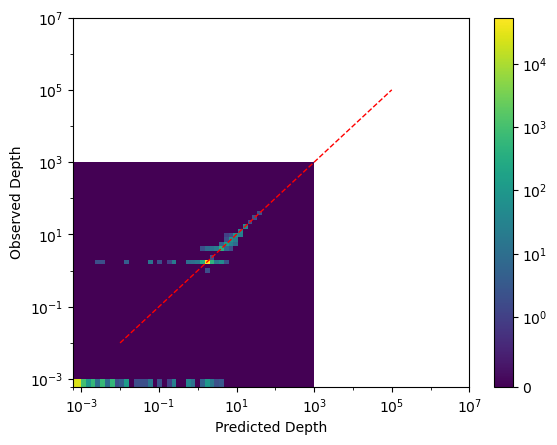

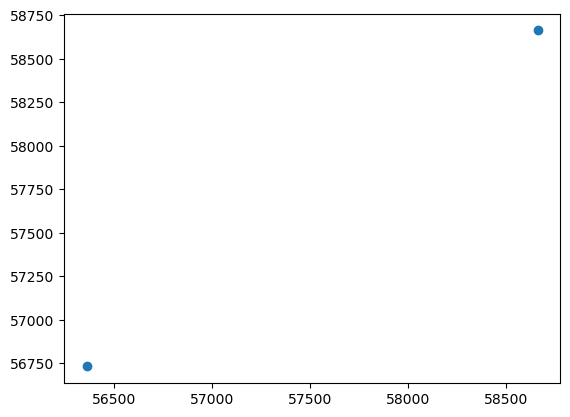

In [17]:
%%time

y, x = obs_segment_depth.align(final_segment_depth, join="left")

left = -3
right = np.ceil(np.log10(max(y.max().max(), x.max().max()))) + 1
bins = np.concatenate([[0], np.logspace(left, right, num=50)])

fig = plt.figure()
plt.hist2d(
    x.values.ravel(),
    y.values.ravel(),
    bins=bins,
    norm=mpl.colors.SymLogNorm(linthresh=1),
)
plt.xscale("symlog", linthresh=1e-3, linscale=0.2)
plt.yscale("symlog", linthresh=1e-3, linscale=0.2)
plt.plot([1e-2, 1e5], [1e-2, 1e5], lw=1, linestyle="--", color="r")
plt.colorbar()

plt.xticks(np.logspace(-3, 7, num=6))
plt.yticks(np.logspace(-3, 7, num=6))
plt.xlabel("Predicted Depth")
plt.ylabel("Observed Depth")

print(sp.stats.pearsonr(x.values.ravel(), y.values.ravel()))

fig = plt.figure()
plt.scatter(x.sum(), y.sum())

In [18]:
sp.stats.pearsonr(x.values.ravel(), y.values.ravel()).statistic ** 2

0.9857201132380509

In [19]:
notips_graph = sz.io.load_graph(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.sz"
)
notips_results = sz.results.extract_vertex_data(notips_graph)
sz.stats.depth_weighted_mean_tig_length(notips_graph)

PropertyArray(456.83994602)

In [20]:
notips_unsmoothed_graph = sz.io.load_graph(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.sz"
)
notips_unsmoothed_results = sz.results.extract_vertex_data(notips_unsmoothed_graph)
sz.stats.depth_weighted_mean_tig_length(notips_unsmoothed_graph)

PropertyArray(456.82229567)

PearsonRResult(statistic=0.9999816886847345, pvalue=0.0)

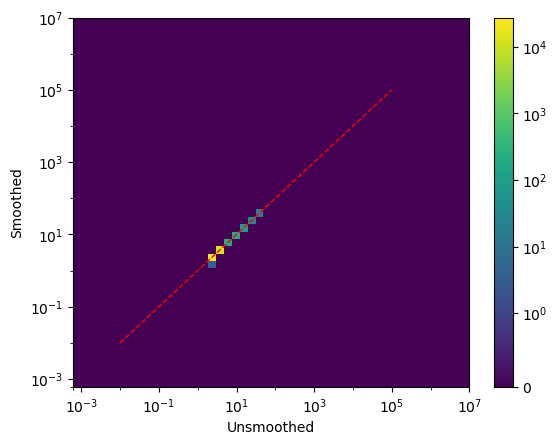

In [21]:
y, x = notips_results.total_depth.align(notips_unsmoothed_results.total_depth)

bins = np.concatenate([[0], np.logspace(-3, 7, num=50)])

fig = plt.figure()
plt.hist2d(x, y, bins=bins, norm=mpl.colors.SymLogNorm(linthresh=1))
plt.xscale("symlog", linthresh=1e-3, linscale=0.2)
plt.yscale("symlog", linthresh=1e-3, linscale=0.2)
plt.plot([1e-2, 1e5], [1e-2, 1e5], lw=1, linestyle="--", color="r")
plt.colorbar()
plt.xticks(np.logspace(-3, 7, num=6))
plt.yticks(np.logspace(-3, 7, num=6))
plt.xlabel("Unsmoothed")
plt.ylabel("Smoothed")

sp.stats.pearsonr(x, y)

In [22]:
round0_graph = sz.io.load_graph(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.checkpoints.d/checkpoint_0.sz"
)
round0_results = sz.results.extract_vertex_data(round0_graph)
print(sz.stats.depth_weighted_mean_tig_length(round0_graph))

round1_graph = sz.io.load_graph(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.checkpoints.d/checkpoint_1.sz"
)
round1_results = sz.results.extract_vertex_data(round1_graph)
print(sz.stats.depth_weighted_mean_tig_length(round1_graph))

round2_graph = sz.io.load_graph(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.checkpoints.d/checkpoint_2.sz"
)
round2_results = sz.results.extract_vertex_data(round2_graph)
print(sz.stats.depth_weighted_mean_tig_length(round2_graph))

round3_graph = sz.io.load_graph(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.checkpoints.d/checkpoint_3.sz"
)
round3_results = sz.results.extract_vertex_data(round3_graph)
print(sz.stats.depth_weighted_mean_tig_length(round3_graph))

round4_graph = sz.io.load_graph(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.checkpoints.d/checkpoint_4.sz"
)
round4_results = sz.results.extract_vertex_data(round4_graph)
print(sz.stats.depth_weighted_mean_tig_length(round4_graph))

round5_graph = sz.io.load_graph(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.checkpoints.d/checkpoint_5.sz"
)
round5_results = sz.results.extract_vertex_data(round5_graph)
print(sz.stats.depth_weighted_mean_tig_length(round5_graph))

round6_graph = sz.io.load_graph(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.checkpoints.d/checkpoint_6.sz"
)
round6_results = sz.results.extract_vertex_data(round6_graph)
print(sz.stats.depth_weighted_mean_tig_length(round6_graph))

round7_graph = sz.io.load_graph(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.checkpoints.d/checkpoint_7.sz"
)
round7_results = sz.results.extract_vertex_data(round7_graph)
print(sz.stats.depth_weighted_mean_tig_length(round7_graph))

round8_graph = sz.io.load_graph(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.checkpoints.d/checkpoint_8.sz"
)
round8_results = sz.results.extract_vertex_data(round8_graph)
print(sz.stats.depth_weighted_mean_tig_length(round8_graph))

# round9_graph = sz.io.load_graph(
#     f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.checkpoints.d/checkpoint_9.sz"
# )
# round9_results = sz.results.extract_vertex_data(round9_graph)
# print(sz.stats.depth_weighted_mean_tig_length(round9_graph))

461.36606225234425
11521.385469115932
17128.32387534561
20836.889275182883
23352.22193739256
23881.99371892553
24091.216760224215
24176.82642707856
24247.534112055968


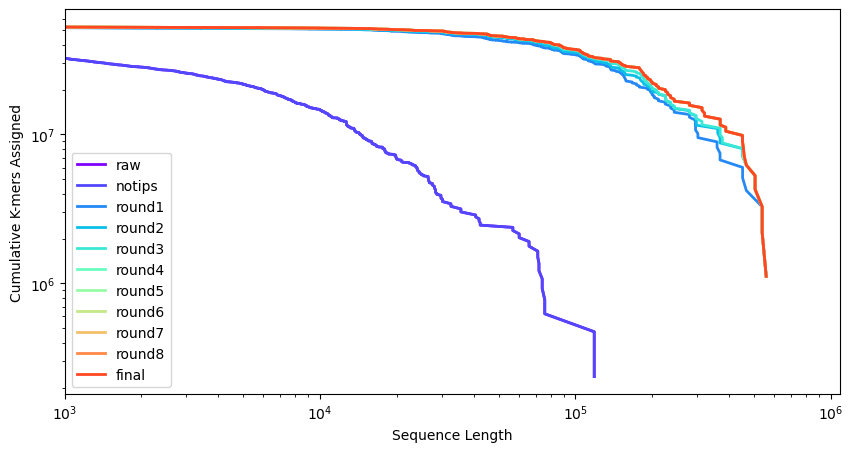

In [23]:
# Overall, we get about 2x as much long sequence depth (distribution of tig lengths of assigned kmers)
fig, ax = plt.subplots(figsize=(10, 5))

_results_mapping = {
    "raw": unpressed_results,
    # 'notips-unsmoothed': unsmoothed_results,
    "notips": notips_results,
    # 'safeonly': safeonly_results,
    "round1": round1_results,
    "round2": round2_results,
    "round3": round3_results,
    "round4": round4_results,
    "round5": round5_results,
    "round6": round4_results,
    "round7": round7_results,
    "round8": round7_results,
    # "round9": round9_results,
    "final": final_results,
    # 'norefs': norefs_results,
    # 'alt1': alt1_results,
    # 'alt3': alt3_results,
    # 'alt4': alt4_results,
    # 'alt5': alt5_results,
}

_cmap = lib.plot.construct_ordered_palette(_results_mapping.keys(), cm="rainbow")


for _label in _results_mapping:
    _results = _results_mapping[_label]
    _c = _cmap[_label]
    d = _results.sort_values("length", ascending=False).assign(
        length_x_depth=lambda x: x.total_depth * x.length,
        length_x_depth_cumsum=lambda x: x.length_x_depth.cumsum(),
    )
    ax.plot("length", "length_x_depth_cumsum", data=d, label=_label, color=_c, lw=2)

ax.set_xlabel("Sequence Length")
ax.set_ylabel("Cumulative K-mers Assigned")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(left=1e3)
# ax.set_ylim(1e9, 4e10)

ax.legend(loc="lower left")  # bbox_to_anchor=(1, 1))
# ax.invert_xaxis()

In [24]:
_results_mapping = {
    "cdBG": unpressed_results,
    "Trim Tips": notips_results,
    "Drop Low Depth": round0_results,
    "Round 1": round1_results,
    "Round 2": round2_results,
    "Round 3": round3_results,
    "Round 4": round4_results,
    "Round 5": round5_results,
    "Round 6": round6_results,
    "Round 7": round7_results,
    "Round 8": round8_results,
    # "Round 9": round9_results,
    "Final": final_results,
    # "k=77": k77_results,
}

In [25]:
depth_weighted_median_tig_length_data = {"Kmer": 1}
depth_unweighted_median_tig_length_data = {"Kmer": 1}
depth_weighted_mean_tig_length_data = {"Kmer": 1}

for round_name in _results_mapping:
    d0 = (
        _results_mapping[round_name]
        .assign(total_kmers=lambda x: x.length * x.total_depth)
        .sort_values("length", ascending=False)
    )
    median_weighted_vertex = (
        (d0.total_kmers.cumsum() / d0.total_kmers.sum()) > 0.5
    ).idxmax()
    median_unweighted_vertex = ((d0.length.cumsum() / d0.length.sum()) > 0.5).idxmax()
    depth_weighted_median_tig_length_data[round_name] = d0.loc[
        median_weighted_vertex
    ].length
    depth_unweighted_median_tig_length_data[round_name] = d0.loc[
        median_unweighted_vertex
    ].length
    depth_weighted_mean_tig_length_data[round_name] = (
        d0.total_kmers.sum() / d0.total_depth.sum()
    )
    print(
        f"{round_name:<15}",
        depth_weighted_median_tig_length_data[round_name],
        depth_unweighted_median_tig_length_data[round_name],
        depth_weighted_mean_tig_length_data[round_name],
        sep="\t",
    )

depth_weighted_median_tig_length_data = pd.Series(depth_weighted_median_tig_length_data)
depth_unweighted_median_tig_length_data = pd.Series(
    depth_weighted_median_tig_length_data
)
depth_weighted_mean_tig_length_data = pd.Series(depth_weighted_mean_tig_length_data)

cdBG           	2790	2107	456.8222956670089
Trim Tips      	2790	2107	456.83994601653865
Drop Low Depth 	2798	2146	461.3660622523442
Round 1        	144292	149957	11521.385469115934
Round 2        	152169	155738	17128.323875345613
Round 3        	167197	173342	20836.889275182883
Round 4        	181088	182556	23352.22193739256
Round 5        	181088	182556	23881.99371892553
Round 6        	181088	182556	24091.216760224215
Round 7        	181088	182556	24176.82642707856
Round 8        	181088	182556	24247.53411205597
Final          	181088	182556	24247.53411205597


/pollard/data/projects/bsmith/strain-aware-assembly/lib/plot.py:493: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


(-0.6000000000000001, 14.0)

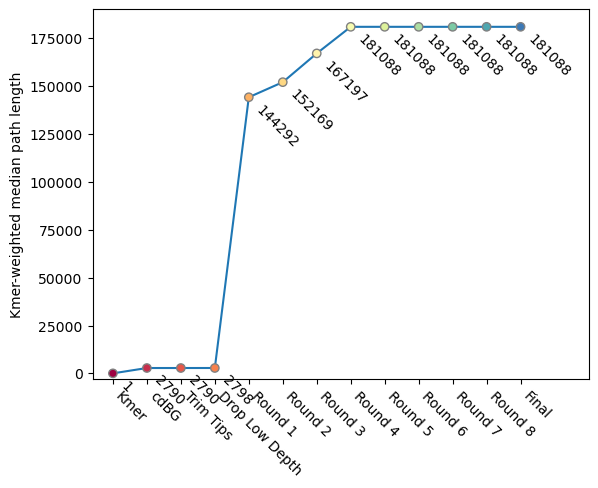

In [26]:
_color_palette = lib.plot.construct_ordered_palette(
    depth_weighted_median_tig_length_data.keys()
)
plt.plot(depth_weighted_median_tig_length_data)
plt.scatter(
    range(len(depth_weighted_median_tig_length_data)),
    depth_weighted_median_tig_length_data.values,
    c=depth_weighted_median_tig_length_data.index.to_series().map(_color_palette),
    edgecolor="grey",
    zorder=2,
)
for x, (_label, y) in enumerate(depth_weighted_median_tig_length_data.items()):
    plt.annotate(
        y,
        xy=(x, y),
        rotation=-45,
        ha="left",
        va="top",
        xytext=(5, -5),
        textcoords="offset pixels",
    )
lib.plot.rotate_xticklabels(rotation=-45, ha="left", va="top")
plt.ylabel("Kmer-weighted median path length")
plt.ylim(bottom=-3000)
plt.xlim(right=14)

/pollard/data/projects/bsmith/strain-aware-assembly/lib/plot.py:493: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


(-0.6000000000000001, 14.0)

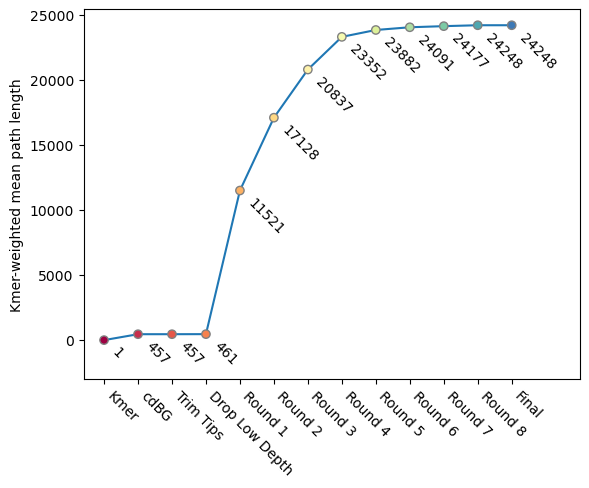

In [37]:
_color_palette = lib.plot.construct_ordered_palette(
    depth_weighted_mean_tig_length_data.keys()
)
plt.plot(depth_weighted_mean_tig_length_data)
plt.scatter(
    range(len(depth_weighted_mean_tig_length_data)),
    depth_weighted_mean_tig_length_data.values,
    c=depth_weighted_mean_tig_length_data.index.to_series().map(_color_palette),
    edgecolor="grey",
    zorder=2,
)
for x, (_label, y) in enumerate(depth_weighted_mean_tig_length_data.items()):
    plt.annotate(
        round(y),
        xy=(x, y),
        rotation=-45,
        ha="left",
        va="top",
        xytext=(5, -5),
        textcoords="offset pixels",
    )
lib.plot.rotate_xticklabels(rotation=-45, ha="left", va="top")
plt.ylabel("Kmer-weighted mean path length")
plt.ylim(bottom=-3000)
plt.xlim(right=14)

## Test Assumptions

In [27]:
d = (
    obs_segment_depth[[0]]
    .rename(columns={0: "depth"})
    .reset_index()
    .assign(strand=lambda x: x.segments.str[-1], unitig=lambda x: x.segments.str[:-1])
    .set_index(["unitig", "strand"])
    .depth.unstack()
)
d.assign(matches=lambda d: d["+"] == d["-"]).matches.mean()

1.0

In [28]:
d = (
    final_segment_depth[[0]]
    .rename(columns={0: "depth"})
    .reset_index()
    .assign(strand=lambda x: x.segments.str[-1], unitig=lambda x: x.segments.str[:-1])
    .set_index(["unitig", "strand"])
    .depth.unstack()
)
print(d.assign(matches=lambda d: d["+"] == d["-"]).matches.mean())
d
# d.assign(matches=lambda d: d['+'] == d['-']).matches.mean()

0.004596380350474002


strand,+,-
unitig,,
0,2.000341,2.000320
1,2.003125,2.003209
10,2.000116,2.000116
100,2.000895,2.000895
1000,2.012590,2.012588
...,...,...
9995,2.000116,2.000116
9996,0.000711,0.000714
9997,0.000632,0.000734


In [29]:
g = notips_graph

d = (
    sz.results.extract_segment_depth(g)[[0]]
    .rename(columns={0: "depth"})
    .reset_index()
    .assign(strand=lambda x: x.segments.str[-1], unitig=lambda x: x.segments.str[:-1])
    .set_index(["unitig", "strand"])
    .depth.unstack()
)
print((d["+"] == d["-"]).mean())
print(np.abs((d["+"] - d["-"])).max())

0.9135305946567078
7.105427357601002e-15


In [33]:
g = notips_unsmoothed_graph

d = (
    sz.results.extract_segment_depth(g)[[0]]
    .rename(columns={0: "depth"})
    .reset_index()
    .assign(strand=lambda x: x.segments.str[-1], unitig=lambda x: x.segments.str[:-1])
    .set_index(["unitig", "strand"])
    .depth.unstack()
)
print((d["+"] == d["-"]).mean())
print(np.abs((d["+"] - d["-"])).max())

1.0
0.0


In [31]:
obs_segment_depth.unstack().value_counts()

2.000000     54608
0.000000     28016
4.000000       448
6.000000       168
10.000000      106
8.000000        98
14.000000       28
18.000000       24
16.000000       20
12.000000       16
2.058606         2
20.000000        2
42.000000        2
32.000000        2
1.053191         2
1.975779         2
Name: count, dtype: int64

## Annotations

### CRISPR

### Phage / Plasmid / AMR

In [ ]:
# Load annotations

phage_positions = pd.read_table(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.genomad.d/contigs_summary/contigs_virus_summary.tsv"
)
prophage_positions = phage_positions[lambda x: x.topology.isin(["Provirus"])].assign(
    vertex=lambda d: d.seq_name.str.split("_").str[0].str.split("|").str[0].astype(int),
    left=lambda d: d.coordinates.str.split("-").str[0].astype(int),
    right=lambda d: d.coordinates.str.split("-").str[1].astype(int),
)

non_prophage_positions = phage_positions[
    lambda x: ~x.topology.isin(["Provirus"])
].assign(
    vertex=lambda d: d.seq_name.str.split("_").str[0].str.split("|").str[0].astype(int),
)

all_phage_positions = phage_positions.assign(
    vertex=lambda d: d.seq_name.str.split("_").str[0].str.split("|").str[0].astype(int),
    # left=lambda d: d.coordinates.str.split("-").str[0].astype(int),
    # right=lambda d: d.coordinates.str.split("-").str[1].astype(int),
)

In [ ]:
plasmid_vertex_annot = pd.read_table(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.genomad.d/contigs_summary/contigs_plasmid_summary.tsv"
).assign(
    vertex=lambda d: d.seq_name.str.split("_").str[0].str.split("|").str[0].astype(int)
)

plasmid_vertex_annot[lambda x: ~x.amr_genes.isna()].sort_values(
    "n_hallmarks", ascending=False
).head(20)

In [ ]:
plasmid_gene_positions = pd.read_table(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.genomad.d/contigs_summary/contigs_plasmid_genes.tsv"
)
plasmid_gene_positions = plasmid_gene_positions[
    lambda x: x.plasmid_hallmark == 1
].assign(
    vertex=lambda d: d.gene.str.split("_").str[0].astype(int),
    left=lambda d: d.start - 1,
    right=lambda d: d.end,
)

plasmid_gene_positions.value_counts("vertex")

In [ ]:
# Load annotations

amr_positions = pd.read_table(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.resfinder.d/ResFinder_results_tab.txt"
)
amr_positions = amr_positions.assign(
    vertex=lambda d: d["Contig"].str.split("_").str[0].astype(int),
    left=lambda d: d["Position in contig"].str.split(".").str[0].astype(int),
    right=lambda d: d["Position in contig"].str.split(".").str[-1].astype(int),
)

In [ ]:
(
    amr_positions
    # [lambda x: x['Resistance gene'] == 'cepA']
    # ['Resistance gene'].value_counts()
)

In [ ]:
# Prophage with an encoded AMR gene.
pd.merge(
    amr_positions,
    all_phage_positions,
    how="inner",
    on="vertex",
    suffixes=["_amr", "_prophage"],
)

In [ ]:
# Plasmid with an encoded AMR gene.
pd.merge(
    amr_positions,
    plasmid_vertex_annot,
    how="inner",
    on="vertex",
    suffixes=["_amr", "_plasmid"],
)

### CRISPR Plasmids

### Mark segments with annotations

In [ ]:
# Compile segments in vertices
segment_positions = sz.results.vertex_segment_positions(
    final_results, segment_length, final_graph.gp["kmer_length"]
)

In [ ]:
prophage_unitig = (
    pd.merge(
        segment_positions,
        prophage_positions,
        on="vertex",
        how="inner",
        suffixes=["_segment", "_feat"],
    )[lambda x: (x.right_segment > x.left_feat) & (x.left_segment < x.right_feat)]
    .segment.str[:-1]
    .unique()
)
len(prophage_unitig)

In [ ]:
non_prophage_positions

In [ ]:
non_prophage_unitig = (
    pd.merge(
        segment_positions,
        non_prophage_positions,
        on="vertex",
        how="inner",
        suffixes=["_segment", "_feat"],
    )
    .segment.str[:-1]
    .unique()
)
len(non_prophage_unitig)

In [ ]:
phage_vertex_unitig = (
    pd.merge(
        segment_positions,
        non_prophage_positions,
        on="vertex",
        how="inner",
        suffixes=["_segment", "_feat"],
    )
    .segment.str[:-1]
    .unique()
)

len(phage_vertex_unitig)

In [ ]:
amr_unitig = (
    pd.merge(
        segment_positions,
        amr_positions,
        on="vertex",
        how="inner",
        suffixes=["_segment", "_feat"],
    )[lambda x: (x.right_segment > x.left_feat) & (x.left_segment < x.right_feat)]
    .segment.str[:-1]
    .unique()
)
len(amr_unitig)

In [ ]:
plasmid_hallmark_unitig = (
    pd.merge(
        segment_positions,
        plasmid_gene_positions,
        on="vertex",
        how="inner",
        suffixes=["_segment", "_feat"],
    )[lambda x: (x.right_segment > x.left_feat) & (x.left_segment < x.right_feat)]
    .segment.str[:-1]
    .unique()
)
len(plasmid_hallmark_unitig)

In [ ]:
amr_prophage_unitig_set = set(amr_unitig) & set(prophage_unitig)
amr_prophage_unitig_vertex_list = idxwhere(
    final_results.segments.apply(
        lambda p: bool(set(s[:-1] for s in p) & amr_prophage_unitig_set)
    )
)
final_results.loc[amr_prophage_unitig_vertex_list]

In [ ]:
phage_positions

In [ ]:
pd.merge(
    amr_positions, phage_positions, left_on="Contig", right_on="seq_name"
)  # .taxonomy.iloc[2]

# Find interesting paths

In [ ]:
final_results[
    lambda x: x.num_segments.gt(100) & x.total_depth.gt(50) & x.complexity.gt(50)
].sort_values("length", ascending=False).head(10)

In [ ]:
final_results.sort_values(["num_segments"], ascending=False).head(50)

In [ ]:
final_results.sort_values(["length"], ascending=False).head(50)

In [ ]:
amr_positions.vertex

In [ ]:
final_results.sort_values(["complexity"], ascending=False).head(10)

In [ ]:
# High complexity paths with AMR genes.
final_results.sort_values(["complexity"], ascending=False).assign(
    has_amr=lambda x: x.index.isin(amr_positions.vertex)
)[lambda x: x.has_amr].head(20)

In [ ]:
final_results.assign(complexity_ratio=lambda x: x.complexity / x.num_segments)[
    lambda x: x.length > 100_000
].sort_values("complexity_ratio", ascending=False).head(10)

In [ ]:
final_results.segments.explode().value_counts().head(10)

In [ ]:
# Use this to find tigs of interest.

final_results.loc[
    sz.results.iter_find_vertices_with_any_segment(final_graph, ["607+"])
].sort_values(["num_segments", "total_depth"], ascending=False)

In [ ]:
d = final_results.assign(
    self_loop=lambda x: x.apply(lambda x: x.name in x.in_neighbors, axis=1)
)

In [ ]:
d[d.self_loop].sort_values("length", ascending=False)

# Focus in one a particular path (and its neighbors)

In [ ]:
focal_path = 215

final_results.loc[focal_path]

In [ ]:
# Select paths that share any vertices with a given path.
focal_segments = list(set(final_results.loc[focal_path].segments))
related_paths = list(
    sz.results.iter_find_vertices_with_any_segment(
        final_graph, final_results.loc[focal_path].segments
    )
)

# # Select paths going through a single segment
# focal_segments = ['1668157+'] # Single focal segment
# related_paths = list(sz.results.iter_find_vertices_with_any_segment(final_graph, focal_segments))

related_segments = list(set(chain(*final_results.loc[related_paths].segments)))
print(len(related_paths), len(related_segments))

# unpressed_graph_focal_vertices = list(sz.results.iter_find_vertices_with_any_segment(unpressed_graph, focal_segments))
unpressed_graph_core_vertices = list(
    sz.results.iter_find_vertices_with_any_segment(unpressed_graph, related_segments)
)
pressed_graph_core_vertices = list(
    sz.results.iter_find_vertices_with_any_segment(notips_graph, related_segments)
)

# in_path = unpressed_graph.new_vertex_property('bool', vals=pd.Series(unpressed_graph.get_vertices()).isin(unpressed_graph_focal_vertices).values)
# path_graph = gt.GraphView(unpressed_graph, vfilt=in_path)
# print(path_graph)

in_core = unpressed_graph.new_vertex_property(
    "bool",
    vals=pd.Series(unpressed_graph.get_vertices())
    .isin(unpressed_graph_core_vertices)
    .values,
)
core_graph = gt.GraphView(unpressed_graph, vfilt=in_core)
print(core_graph)

# in_core_pressed = notips_graph.new_vertex_property('bool', vals=pd.Series(notips_graph.get_vertices()).isin(pressed_graph_core_vertices).values)
# core_graph_pressed = gt.GraphView(notips_graph, vfilt=in_core_pressed)
# print(core_graph_pressed)

final_results.loc[related_paths].sort_values("num_segments", ascending=False)

In [ ]:
# # Select paths that share any vertices with a given path.
# focal_segments = list(set(final_results.loc[focal_path].segments))
# related_paths = list(sz.results.iter_find_vertices_with_any_segment(final_graph, final_results.loc[focal_path].segments))

# # # Select paths going through a single segment
# # focal_segments = ['1668157+'] # Single focal segment
# # related_paths = list(sz.results.iter_find_vertices_with_any_segment(final_graph, focal_segments))

# related_segments = list(set(chain(*final_results.loc[related_paths].segments)))
# print(len(related_paths), len(related_segments))


path_membership = (
    final_results.loc[related_paths]
    .segments.explode()
    .reset_index()
    .value_counts()
    .unstack(fill_value=0)
)
_obs_segment_depth = obs_segment_depth.loc[path_membership.columns].T
est_path_depth = vertex_depth.T[related_paths]
pred_unitig_depth = final_segment_depth.loc[path_membership.columns].T
resid_unitig_depth = _obs_segment_depth - pred_unitig_depth
relative_resid_unitig_depth = resid_unitig_depth / (pred_unitig_depth + 1)

max_obs = _obs_segment_depth.max().max()
max_resid = np.abs(relative_resid_unitig_depth).max().max()


clust_palette = lib.plot.construct_ordered_palette(
    vertex_to_clust.loc[related_paths].values
)
path_colors = pd.DataFrame(
    dict(clust=vertex_to_clust.loc[related_paths].map(clust_palette))
)
segment_colors = pd.DataFrame(
    dict(
        prophage=path_membership.columns.to_series()
        .str[:-1]
        .isin(prophage_unitig)
        .map({True: "black", False: "grey"}),
        anyphage=path_membership.columns.to_series()
        .str[:-1]
        .isin(list(prophage_unitig) + list(non_prophage_unitig))
        .map({True: "black", False: "grey"}),
        amr=path_membership.columns.to_series()
        .str[:-1]
        .isin(amr_unitig)
        .map({True: "black", False: "grey"}),
        plasmid=path_membership.columns.to_series()
        .str[:-1]
        .isin(plasmid_hallmark_unitig)
        .map({True: "black", False: "grey"}),
        # crispr=path_membership.columns.to_series()
        # .str[:-1]
        # .isin(crispr_unitig)
        # .map({True: "black", False: "grey"}),
        length=segment_length.loc[path_membership.columns].map(mpl.cm.viridis),
    )
)

# unitig_linkage = fastcluster.linkage(_obs_segment_depth.T, metric='euclidean', method='average')
unitig_linkage = fastcluster.linkage(
    pred_unitig_depth.T, metric="cosine", method="average"
)
path_linkage = fastcluster.linkage(est_path_depth.T, metric="cosine", method="average")
sample_linkage = fastcluster.linkage(
    _obs_segment_depth ** (1 / 3) + 1, metric="cosine", method="average"
)

try:
    sns.clustermap(
        est_path_depth,
        row_linkage=sample_linkage,
        col_linkage=path_linkage,
        col_colors=path_colors,
        yticklabels=0,
        xticklabels=1,
        figsize=(3, 3),
        norm=mpl.colors.SymLogNorm(1e-1, vmin=0, vmax=max_obs),
    )
    sns.clustermap(
        est_path_depth.T,
        col_linkage=sample_linkage,
        row_linkage=path_linkage,
        row_colors=path_colors,
        xticklabels=0,
        yticklabels=1,
        figsize=(3, 3),
        norm=mpl.colors.SymLogNorm(1e-1, vmin=0, vmax=max_obs),
    )
    sns.clustermap(
        path_membership,
        row_linkage=path_linkage,
        col_linkage=unitig_linkage,
        row_colors=path_colors,
        col_colors=segment_colors,
        figsize=(15, 5),
        xticklabels=0,
        yticklabels=1,
        norm=mpl.colors.SymLogNorm(1, vmin=0),
    )
except ValueError as err:
    print(err)

sns.clustermap(
    _obs_segment_depth,
    row_linkage=sample_linkage,
    col_linkage=unitig_linkage,
    col_colors=segment_colors,
    figsize=(15, 5),
    norm=mpl.colors.SymLogNorm(1e-1, vmin=0, vmax=max_obs),
    xticklabels=0,
)
sns.clustermap(
    pred_unitig_depth,
    row_linkage=sample_linkage,
    col_linkage=unitig_linkage,
    col_colors=segment_colors,
    figsize=(15, 5),
    norm=mpl.colors.SymLogNorm(1e-1, vmin=0, vmax=max_obs),
    xticklabels=0,
)
sns.clustermap(
    relative_resid_unitig_depth,
    row_linkage=sample_linkage,
    col_linkage=unitig_linkage,
    col_colors=segment_colors,
    figsize=(15, 5),
    norm=mpl.colors.SymLogNorm(1e-1, vmin=-max_resid, vmax=max_resid),
    cmap="coolwarm",
    xticklabels=0,
)

In [ ]:
est_path_depth.divide(
    total_marker_depth,
    axis=0,
).loc[
    idxwhere(mgen_meta.subject_id == "DA")
].rename(mgen_meta.collection_date).sort_index().plot.line(color=path_colors.clust)
plt.yscale("symlog", linthresh=1e-4)
plt.ylim(-1e-5)
lib.plot.rotate_xticklabels()
plt.legend(bbox_to_anchor=(1, 1))

In [ ]:
est_path_depth.divide(
    total_marker_depth,
    axis=0,
).loc[
    idxwhere(mgen_meta.subject_id == "DAR03")
].rename(mgen_meta.collection_date).sort_index().plot.line(color=path_colors.clust)
plt.yscale("symlog", linthresh=1e-4)
plt.ylim(-1e-5)
lib.plot.rotate_xticklabels()
plt.legend(bbox_to_anchor=(1, 1))

### Plot comparative networks

In [ ]:
try:
    os.mkdir(f"{fig_dir}/neighborhood-{focal_path}/")
except FileExistsError:
    pass

In [ ]:
%%time
unpressed_graph_distance_to_core = sz.topology.get_shortest_distance_to_any_vertex(
    unpressed_graph, unpressed_graph_core_vertices, unpressed_graph.vp["length"]
)

In [ ]:
radius = 0

in_neighborhood = unpressed_graph.new_vertex_property(
    "bool", vals=unpressed_graph_distance_to_core.a <= radius
)
neighborhood_graph = gt.GraphView(unpressed_graph, vfilt=in_neighborhood)
neighborhood_graph

In [ ]:
_graph = gt.Graph(neighborhood_graph, prune=True)


_backlinked_graph = sz.topology.backlinked_graph(_graph)
_edge_length = gt.edge_endpoint_property(
    _backlinked_graph, _backlinked_graph.vp["length"], "source"
)
_segments = list(_backlinked_graph.vp["sequence"])

unitig_shortest_pdist = gt.topology.shortest_distance(
    _backlinked_graph, directed=False, weights=_edge_length
).get_2d_array(pos=range(len(_backlinked_graph)))

unitig_shortest_path_linkage = fastcluster.linkage(
    unitig_shortest_pdist, method="average"
)

sns.clustermap(
    pd.DataFrame(unitig_shortest_pdist, index=_segments, columns=_segments),
    col_linkage=unitig_shortest_path_linkage,
    row_linkage=unitig_shortest_path_linkage,
    norm=mpl.colors.SymLogNorm(1),
)

In [ ]:
# sample_for_depth = 118

_graph = gt.Graph(neighborhood_graph, prune=True)
# _graph = gt.Graph(core_graph_pressed, prune=True)
# _graph = gt.Graph(path_graph, prune=True)
# _graph = gt.Graph(neighborhood_graph_final, prune=True)

gt.seed_rng(1)
np.random.seed(2)
sz.draw.update_xypositions(
    _graph, layout=gt.draw.random_layout, shape=(10, 10)
)  # NOTE: This allows for reproducible layouts.
sz.draw.update_xypositions(_graph, layout=gt.draw.sfdp_layout, p=1.7, K=1)


vertex_color = _graph.new_vertex_property(
    "float", vals=np.log(sz.results.total_depth_property(_graph).a + 1)
)
vertex_size = _graph.new_vertex_property(
    "float",
    vals=20 + np.log(_graph.vp["length"].a) * 4,
)


outpath = f"{fig_dir}/neighborhood-{focal_path}/length.pdf"
sz.draw.draw_graph(
    _graph,
    vertex_text=_graph.vp["length"],
    vertex_size=vertex_size,
    vertex_font_size=16,
    vertex_fill_color=vertex_color,
    output=outpath,
    vcmap=(mpl.cm.magma, 1),
    output_size=(1000, 1000),
)
print(outpath)

outpath = f"{fig_dir}/neighborhood-{focal_path}/segment.pdf"
sz.draw.draw_graph(
    _graph,
    vertex_text=_graph.vp["sequence"],
    vertex_size=vertex_size,
    vertex_font_size=4,
    vertex_fill_color=vertex_color,
    output=outpath,
    vcmap=(mpl.cm.magma, 1),
    output_size=(1000, 1000),
)
print(outpath)

In [ ]:
# Phage
_vertices = list(
    sz.results.iter_find_vertices_with_any_segment(
        _graph,
        [u + "+" for u in prophage_unitig]
        + [u + "-" for u in prophage_unitig]
        + [u + "+" for u in non_prophage_unitig]
        + [u + "-" for u in non_prophage_unitig],
    )
)
print(len(_vertices))
in_set = _graph.new_vertex_property("bool", val=False)
in_set.a[_vertices] = 1

outpath = f"{fig_dir}/neighborhood-{focal_path}/phage.pdf"
sz.draw.draw_graph(
    _graph,
    vertex_text="",
    vertex_halo=in_set,
    vertex_size=vertex_size,
    vertex_font_size=16,
    vertex_fill_color=vertex_color,
    output=outpath,
    vcmap=(mpl.cm.magma, 1),
    output_size=(1000, 1000),
)
# sz.draw.draw_graph(
#     _graph,
#     # vertex_text=_graph.vp['sequence'],
#     # vertex_text=_graph.vp['length'],
#     vertex_text="",
#     vertex_halo=in_set,
#     vorder=in_set.transform(lambda x: x.astype(float)),
#     vertex_font_size=5,
#     vertex_fill_color=vertex_color,
#     # edge_pen_width=10,
#     output=outpath,
#     vcmap=(mpl.cm.magma, 1),
#     output_size=(400, 400),
# )
print(outpath)

# Phage
_vertices = list(
    sz.results.iter_find_vertices_with_any_segment(
        _graph, [u + "+" for u in amr_unitig] + [u + "-" for u in amr_unitig]
    )
)
print(len(_vertices))
in_set = _graph.new_vertex_property("bool", val=False)
in_set.a[_vertices] = 1

outpath = f"{fig_dir}/neighborhood-{focal_path}/amr.pdf"
sz.draw.draw_graph(
    _graph,
    vertex_text="",
    vertex_halo=in_set,
    vertex_size=vertex_size,
    vertex_font_size=16,
    vertex_fill_color=vertex_color,
    output=outpath,
    vcmap=(mpl.cm.magma, 1),
    output_size=(1000, 1000),
)
print(outpath)


# Plasmid
_vertices = list(
    sz.results.iter_find_vertices_with_any_segment(
        _graph,
        [u + "+" for u in plasmid_hallmark_unitig]
        + [u + "-" for u in plasmid_hallmark_unitig],
    )
)
print(len(_vertices))
in_set = _graph.new_vertex_property("bool", val=False)
in_set.a[_vertices] = 1

outpath = f"{fig_dir}/neighborhood-{focal_path}/plasmid.pdf"
sz.draw.draw_graph(
    _graph,
    vertex_text="",
    vertex_halo=in_set,
    vertex_size=vertex_size,
    vertex_font_size=16,
    vertex_fill_color=vertex_color,
    output=outpath,
    vcmap=(mpl.cm.magma, 1),
    output_size=(1000, 1000),
)
print(outpath)


# # CRISPR
# _vertices = list(
#     sz.results.iter_find_vertices_with_any_segment(
#         _graph,
#         [u + "+" for u in crispr_unitig] + [u + "-" for u in crispr_unitig],
#     )
# )
# print(len(_vertices))
# in_set = _graph.new_vertex_property("bool", val=False)
# in_set.a[_vertices] = 1

# outpath = f"{fig_dir}/neighborhood-{focal_path}/crispr.pdf"
# sz.draw.draw_graph(
#     _graph,
#     vertex_text="",
#     vertex_halo=in_set,
#     vertex_size=vertex_size,
#     vertex_font_size=16,
#     vertex_fill_color=vertex_color,
#     output=outpath,
#     vcmap=(mpl.cm.magma, 1),
#     output_size=(1000, 1000),
# )
# print(outpath)

In [ ]:
n_top = 10

top_vertex_list = list(
    set(
        final_results.loc[related_paths]
        .sort_values("num_segments", ascending=False)
        .head(n_top)
        .index
    )
    | set(
        final_results.loc[related_paths]
        .sort_values("length", ascending=False)
        .head(n_top)
        .index
    )
    | set(
        final_results.loc[related_paths]
        .sort_values("total_depth", ascending=False)
        .head(n_top)
        .index
    )
)

for path in top_vertex_list:
    _vertices = list(
        sz.results.iter_find_vertices_with_any_segment(
            _graph, final_results.loc[path].segments
        )
    )
    print(len(_vertices))
    in_path = _graph.new_vertex_property("bool", val=False)
    in_path.a[_vertices] = 1
    outpath = f"{fig_dir}/neighborhood-{focal_path}/{path}.pdf"
    sz.draw.draw_graph(
        _graph,
        vertex_text="",
        vertex_halo=in_path,
        vertex_halo_color=clust_palette[final_results.loc[path, "clust"]],
        vertex_size=vertex_size,
        vertex_font_size=16,
        vertex_fill_color=vertex_color,
        output=outpath,
        vcmap=(mpl.cm.magma, 1),
        output_size=(1000, 1000),
    )
    print(outpath)

### Visualize complex graph

In [ ]:
radius = 0

in_neighborhood = unpressed_graph.new_vertex_property(
    "bool", vals=unpressed_graph_distance_to_core.a <= radius
)
big_neighborhood_graph = gt.GraphView(unpressed_graph, vfilt=in_neighborhood)
print(big_neighborhood_graph)

In [ ]:
_graph = gt.Graph(big_neighborhood_graph, prune=True)

gt.seed_rng(1)
np.random.seed(2)
sz.draw.update_xypositions(
    _graph, layout=gt.draw.random_layout, shape=(10, 10)
)  # NOTE: This allows for reproducible layouts.
sz.draw.update_xypositions(_graph, layout=gt.draw.sfdp_layout, p=3, K=1)

In [ ]:
vertex_color = _graph.new_vertex_property(
    "float", vals=np.log(sz.results.total_depth_property(_graph).a + 1)
)


outpath = f"{fig_dir}/neighborhood-{focal_path}/big_neighborhood.pdf"
sz.draw.draw_graph(
    _graph,
    vertex_text="",
    # vertex_fill_color='grey',
    output=outpath,
    # vcmap=(mpl.cm.magma, 1),
    output_size=(1000, 1000),
    ink_scale=1.4,
    bg_color="black",
    edge_color="white",
    vertex_fill_color="white",
)
print(outpath)

In [ ]:
_path = 2332452

_vertices = list(
    sz.results.iter_find_vertices_with_any_segment(
        _graph, final_results.loc[_path].segments
    )
)
print(len(_vertices))
in_path = _graph.new_vertex_property("string", val="grey")
for v in _vertices:
    in_path[v] = "red"


outpath = f"{fig_dir}/neighborhood-{focal_path}/big_neighborhood-{_path}.pdf"
sz.draw.draw_graph(
    _graph,
    vertex_text="",
    vertex_fill_color=in_path,
    # vertex_halo=in_path,
    output=outpath,
    # vcmap=(mpl.cm.bwr, 1),
    output_size=(1000, 1000),
    ink_scale=1.4,
    bg_color="black",
    edge_color="white",
)
print(outpath)

In [ ]:
_path = 2355507

_vertices = list(
    sz.results.iter_find_vertices_with_any_segment(
        _graph, final_results.loc[_path].segments
    )
)
print(len(_vertices))
in_path = _graph.new_vertex_property("string", val="grey")
for v in _vertices:
    in_path[v] = "blue"


outpath = f"{fig_dir}/neighborhood-{focal_path}/big_neighborhood-{_path}.pdf"
sz.draw.draw_graph(
    _graph,
    vertex_text="",
    vertex_fill_color=in_path,
    # vertex_halo=in_path,
    output=outpath,
    # vcmap=(mpl.cm.bwr, 1),
    output_size=(1000, 1000),
    ink_scale=1.4,
    bg_color="black",
    edge_color="white",
)
print(outpath)

In [ ]:
_path = 2388163

_vertices = list(
    sz.results.iter_find_vertices_with_any_segment(
        _graph, final_results.loc[_path].segments
    )
)
print(len(_vertices))
in_path = _graph.new_vertex_property("string", val="grey")
for v in _vertices:
    in_path[v] = "green"


outpath = f"{fig_dir}/neighborhood-{focal_path}/big_neighborhood-{_path}.pdf"
sz.draw.draw_graph(
    _graph,
    vertex_text="",
    vertex_fill_color=in_path,
    # vertex_halo=in_path,
    output=outpath,
    # vcmap=(mpl.cm.bwr, 1),
    output_size=(1000, 1000),
    ink_scale=1.4,
    bg_color="black",
    edge_color="white",
)
print(outpath)

### Visualize Clusters

In [ ]:
focal_clust = 7732

_vertices = idxwhere(final_results.clust == focal_clust)
print(len(_vertices))
_segments = set(
    final_results[lambda x: x.clust == focal_clust].segments.explode().unique()
)
print(len(_segments))
# print(final_results[lambda x: x.clust == focal_clust].length.sum(), len(_segments_list))

# sns.clustermap(obs_segment_depth.loc[_segments_list] + 0.001, norm=mpl.colors.SymLogNorm(0.1), metric='cosine')
# sns.clustermap(vertex_depth.loc[idxwhere(final_results.clust == focal_clust)] + 0.001, norm=mpl.colors.SymLogNorm(0.1), metric='cosine')

if len(_vertices) < 1_000:
    sns.clustermap(
        vertex_depth.loc[_vertices], norm=mpl.colors.SymLogNorm(1e-2), metric="cosine"
    )

print(final_results[lambda x: x.clust == focal_clust][["length", "num_segments"]].sum())
final_results[lambda x: x.clust == focal_clust].sort_values(
    "length", ascending=False
).head()

# path_membership = (
#     final_results.loc[related_paths]
#     .segments.explode()
#     .reset_index()
#     .value_counts()
#     .unstack(fill_value=0)
# )
# _obs_segment_depth = obs_segment_depth.loc[path_membership.columns].T

In [ ]:
in_segments = unpressed_graph.new_vertex_property("bool")
gt.map_property_values(
    unpressed_graph.vp["sequence"], in_segments, lambda x: x in _segments
)
assert in_segments.a.sum() == len(_segments)

In [ ]:
clust_segment_graph = gt.GraphView(unpressed_graph, vfilt=in_segments)
clust_segment_graph

In [ ]:
_graph = gt.Graph(clust_segment_graph, prune=True)

gt.seed_rng(1)
np.random.seed(2)
sz.draw.update_xypositions(
    _graph, layout=gt.draw.random_layout, shape=(10, 10)
)  # NOTE: This allows for reproducible layouts.
sz.draw.update_xypositions(_graph, layout=gt.draw.sfdp_layout, p=1.7, K=1)
print("Done with layout.")

vertex_color = _graph.new_vertex_property(
    "float", vals=np.log(sz.results.total_depth_property(_graph).a + 1)
)
vertex_size = _graph.new_vertex_property(
    "float",
    vals=np.log(_graph.vp["length"].a + 1) * 4,
)

# Highlight vertices in the cluster itself.
_vertices = list(sz.results.iter_find_vertices_with_any_segment(_graph, _segments))
print(len(_vertices))
in_path = _graph.new_vertex_property("bool", val=False)
in_path.a[_vertices] = 1


outpath = f"{fig_dir}/clust-{focal_clust}.pdf"
sz.draw.draw_graph(
    _graph,
    vertex_text=_graph.vp["length"],
    vertex_halo=in_path,
    vertex_size=vertex_size,
    vertex_font_size=16,
    vertex_fill_color=vertex_color,
    output=outpath,
    vcmap=(mpl.cm.magma, 1),
    output_size=(1000, 1000),
)

# sz.draw.draw_graph(
#     _graph,
#     # vertex_text=_graph.vp['length'],
#     vertex_text=_graph.vp["sequence"],
#     vertex_halo=in_path,
#     # vertex_font_size=5,
#     vertex_fill_color=vertex_color,
#     # edge_pen_width=10,
#     output=outpath,
#     vcmap=(mpl.cm.magma, 1),
#     output_size=(1000, 1000),
# )
print(outpath)

In [ ]:
_cross_correlation.loc[x_id].idxmax()

In [ ]:
path_order = [184977, 210689, 187913]
_palette = {184977: "dodgerblue", 210689: "limegreen", 187913: "hotpink"}
_rename_strain = {
    "Veillonella-sp-3-1-44": "Veillonella parvulla Strain A",
    "Veillonella-sp-6-1-27": "Veillonella parvulla Strain B",
    "Veillonella-dispar-ATCC-17748": "Veillonella dispar",
}

x = normalized_vertex_depth.loc[path_order]
y = kraken_rabund.T
_cross_correlation = pd.DataFrame(
    1 - sp.spatial.distance.cdist(x, y, metric="cosine"), index=x.index, columns=y.index
)


fig, axs = lib.plot.subplots_grid(ncols=3, naxes=len(path_order), ax_height=3.5)

for x_id, ax in zip(x.index, axs.flatten()):
    y_id = _cross_correlation.loc[x_id].idxmax()
    print(y_id)

    max_val = max(x.loc[x_id].max(), y.loc[y_id].max())

    ax.scatter(x.loc[x_id], y.loc[y_id], s=15, color=_palette[x_id])
    ax.plot([0, 1], [0, 1], color="k", linestyle="--")
    ax.set_xscale("symlog", linthresh=1e-4, linscale=0.25)
    ax.set_yscale("symlog", linthresh=1e-4, linscale=0.25)
    ax.set_xlabel(f"Path {x_id}")
    ax.set_ylabel(_rename_strain[y_id], fontstyle="italic")
    ax.set_aspect(1)
    ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e-0])
    # ax.annotate('{:0.01e}'.format(clust_meta.loc[clust_id].total_length), xy=(0.6, 0.3), xycoords='axes fraction')
    # cross_correlation.loc[strain_id].sort_values(ascending=False).head()

fig.tight_layout()

In [ ]:
clust_depth = (
    pd.read_table(
        f"data/group/{group}/r.proc.kmtricks-{kmtricks}.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.clust-{clust_params}.depth.tsv"
    )
    .rename(columns={"Unnamed: 0": "cluster"})
    .set_index("cluster")
    .T.rename(int)
)
sns.clustermap(
    clust_depth.rename(sample_idx_to_id).loc[
        :, idxwhere(clust_meta.total_length > 1_000_000)
    ],
    metric="cosine",
    norm=mpl.colors.SymLogNorm(1),
)

In [ ]:
clust_rabund = clust_depth.divide(marker_depth.sum(1), axis=0)

sns.clustermap(
    clust_rabund[idxwhere(clust_meta.total_length > 1_000_000)].rename(
        sample_idx_to_id
    ),
    norm=mpl.colors.SymLogNorm(1e-5),
    metric="cosine",
)

In [ ]:
x = kraken_rabund
y = clust_rabund[idxwhere(clust_meta.total_length > 2_000_000)].rename(sample_idx_to_id)

x, y = x.align(y, join="inner", axis="index")

cross_correlation = pd.DataFrame(
    1 - sp.spatial.distance.cdist(x.T, y.T, metric="cosine"),
    index=x.columns,
    columns=y.columns,
)

sns.clustermap(cross_correlation)

In [ ]:
_strain_id_list = kraken_rabund.columns

fig, axs = lib.plot.subplots_grid(ncols=5, naxes=len(_strain_id_list))

for strain_id, ax in zip(_strain_id_list, axs.flatten()):
    clust_id = cross_correlation.loc[strain_id].idxmax()

    max_val = max(x[strain_id].max(), y[clust_id].max())

    ax.scatter(x[strain_id], y[clust_id])
    ax.plot([0, max_val], [0, max_val])
    ax.set_xscale("symlog", linthresh=1e-5)
    ax.set_yscale("symlog", linthresh=1e-5)
    ax.set_xlabel(strain_id)
    ax.set_ylabel(f"bin {clust_id}")
    ax.set_aspect(1)
    ax.annotate(
        "{:0.01e}".format(clust_meta.loc[clust_id].total_length),
        xy=(0.6, 0.3),
        xycoords="axes fraction",
    )
    # cross_correlation.loc[strain_id].sort_values(ascending=False).head()

fig.tight_layout()

In [ ]:
strain_id = "Bacteroides-thetaiotaomicron-VPI-5482"

fig, ax = plt.subplots()

clust_id = cross_correlation.loc[strain_id].idxmax()

max_val = max(x[strain_id].max(), y[clust_id].max())

ax.scatter(x[strain_id], y[clust_id])
ax.plot([0, max_val], [0, max_val])
ax.set_xlabel(strain_id)
ax.set_ylabel(f"bin {clust_id}")
ax.annotate(
    "{:0.01e}".format(clust_meta.loc[clust_id].total_length),
    xy=(0.6, 0.3),
    xycoords="axes fraction",
)
# ax.set_xscale('symlog', linthresh=1e-5)
# ax.set_yscale('symlog', linthresh=1e-5)
ax.set_aspect(1)
# fig.tight_layout()
cross_correlation.loc[strain_id].sort_values(ascending=False).head()

In [ ]:
focal_clust = 20

focal_clusts = [
    focal_clust,
    # 2383,
    338,
    332,
]

clust_palette = lib.plot.construct_ordered_palette(focal_clusts, cm="tab20")

focal_clust_segments = idxwhere(segement_x_clust == focal_clust)

d = final_results.loc[idxwhere(vertex_to_clust.isin(focal_clusts))].sort_values(
    "length", ascending=False
)  # .head(20)

for clust in focal_clusts:
    color = clust_palette[clust]
    plt.scatter(
        "length",
        "total_depth",
        data=d.loc[idxwhere(vertex_to_clust == clust)],
        s=4,
        label=clust,
        color=color,
    )
plt.xscale("log")
plt.yscale("log")
plt.legend()

print(d.length.sum())
d.join(vertex_to_clust).sort_values("num_segments", ascending=False)

In [ ]:
_col_colors = d.length.pipe(np.log10).pipe(lambda x: mpl.cm.viridis(x / x.max()))
# _col_colors = d.index.to_series().map(vertex_to_clust).map(clust_palette)

sns.clustermap(
    vertex_depth.loc[d.index].T.rename(sample_idx_to_id),
    col_colors=_col_colors,
    metric="cosine",
    norm=mpl.colors.SymLogNorm(linthresh=1),
)

In [ ]:
cg = sns.clustermap(
    vertex_depth.loc[idxwhere(d.length > 1000)].T.rename(sample_idx_to_id),
    metric="cosine",
    norm=mpl.colors.SymLogNorm(linthresh=0.01),
    figsize=(6, 2.5),
    dendrogram_ratio=(0, 0.2),
    xticklabels=0,
    yticklabels=0,
)

cg.ax_cbar.set_visible(False)

In [ ]:
clust_neighborhood_segment_graph = sz.io.load_graph(
    f"data/group/{group}/r.proc.kmtricks-{kmtricks}.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.clust-{clust_params}.unassembled-c{focal_clust}-r100.notips-1-unpressed.sz"
)
sz.results.extract_vertex_data(clust_neighborhood_segment_graph).sort_values(
    "length", ascending=False
)  # .head(20)

In [ ]:
_graph = clust_neighborhood_segment_graph


sz.draw.update_xypositions(_graph)
print("Done with layout.")

# Color by depth
vertex_color = _graph.new_vertex_property(
    "float", vals=np.log(sz.results.total_depth_property(_graph).a + 1)
)

# Highlight vertices in the cluster itself.
_vertices = list(
    sz.results.iter_find_vertices_with_any_segment(_graph, focal_clust_segments)
)
print(len(_vertices))
in_path = _graph.new_vertex_property("bool", val=False)
in_path.a[_vertices] = 1

outpath = f"{fig_dir}/clust-{focal_clust}.pdf"
sz.draw.draw_graph(
    _graph,
    # vertex_text=_graph.vp['length'],
    vertex_text=_graph.vp["sequence"],
    vertex_halo=in_path,
    # vertex_font_size=5,
    vertex_fill_color=vertex_color,
    # edge_pen_width=10,
    output=outpath,
    vcmap=(mpl.cm.magma, 1),
    output_size=(1000, 1000),
)
print(outpath)

In [ ]:
segment_x_cluster = pd.read_table(
    f"data/group/{group}/r.proc.kmtricks-{kmtricks}.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.clust-{clust_params}.segment.tsv"
)

In [ ]:
%%time
radius = 10

focal_clusts = [
    20,
    # 2383,
    338,
    332,
]

# Select segments
_segment_list = list(
    segment_x_cluster[lambda x: x.cluster.isin(focal_clusts)]
    .segment.drop_duplicates()
    .values
)

# Select vertices
_vertex_list = list(
    sz.results.iter_find_vertices_with_any_segment(unpressed_graph, _segment_list)
)
# Find neighborhood
_distance_from_focal = sz.topology.get_shortest_distance_to_any_vertex(
    unpressed_graph, _vertex_list, unpressed_graph.vp["length"]
)
_vertex_mask = unpressed_graph.new_vertex_property(
    "bool", vals=_distance_from_focal.a <= radius
)
_neighborhood_vertex_list = idxwhere(
    pd.DataFrame(
        unpressed_graph.get_vertices(vprops=[_vertex_mask]), columns=["vertex", "mask"]
    ).set_index("vertex")["mask"]
    == 1
)
_graph0 = gt.Graph(gt.GraphView(unpressed_graph, vfilt=_vertex_mask), prune=True)
print(_graph0)

# Layout graph
gt.seed_rng(1)
np.random.seed(2)
sz.draw.update_xypositions(
    _graph0, layout=gt.draw.random_layout
)  # NOTE: This allows for reproducible layouts.
print("Done with Step 1.")
sz.draw.update_xypositions(
    _graph0,
    layout=gt.draw.sfdp_layout,
    # p=1.4,
    # K=1,
)
print("Done with layout!")

In [ ]:
# _palette = {332: 'fuchsia', 2383: 'silver', 20: 'lime', 338: 'cyan'}
_palette = {332: "hotpink", 2383: "silver", 20: "limegreen", 338: "dodgerblue"}

In [ ]:
# Decorate vertices
_results = sz.results.extract_vertex_data(_graph0)
_segment_to_vertex = (
    _results.segments.str[0]
    .reset_index()
    .set_index("segments")
    .vertex.rename_axis(index="segment")
)

clust_membership = (
    final_results[lambda x: x.clust.isin(focal_clusts)]
    .groupby("clust")
    .apply(lambda x: x.segments.explode().drop_duplicates(), include_groups=False)
    .rename("segment")
    .reset_index()
    .set_index(["clust", "segment"])
    .assign(tally=1)
    .tally.unstack(fill_value=0)
    .T.rename(_segment_to_vertex)
    .reindex(_graph0.get_vertices(), fill_value=0)
    # .sort_index()
)

In [ ]:
# num_clusts = 3
# _clusts1 = focal_clusts[:num_clusts]

_clust_order = [
    332,
    20,
    # 2383,
    338,
]

_clusts1 = _clust_order
_graph1 = _graph0.copy()

# # Select vertices in bin.
# _clusts1 = _clust_order[:i + 1]
# _mask1 = sz.results.extract_vertex_data(_graph0).segments.str[0].isin(segment_x_cluster[lambda x: x.cluster.isin(_clusts1)].segment)
# print(_mask1.mean())
# _graph1 = gt.GraphView(_graph0, vfilt=_mask1)

# # Decorate vertices
# _clust_mem = clust_membership[_mask1][_clusts1]
# _clust_frac1 = _clust_mem.divide(_clust_mem.sum(axis=1), axis=0)
# _graph1.vp['clust_frac'] = _graph1.new_vertex_property('vector<float>', vals=_clust_frac1.sort_index().values)

# Decorate vertices
_color_subset = (
    sz.results.extract_vertex_data(_graph0)
    .segments.str[0]
    .isin(segment_x_cluster[lambda x: x.cluster.isin(_clusts1)].segment)
)
_clust_mem = clust_membership[_color_subset][_clusts1]
_clust_frac1 = _clust_mem.divide(_clust_mem.sum(axis=1), axis=0).reindex(
    _graph1.get_vertices(), fill_value=0
)
_clust_frac_vprop = _graph1.new_vertex_property(
    "vector<float>", vals=_clust_frac1.sort_index().values
)

outpath = f"{fig_dir}/Veill-multibin.all.png"
sz.draw.draw_graph(
    _graph1,
    output=outpath,
    vertex_text="",
    # vertex_color='k',
    vertex_size=30,
    vertex_shape="pie",
    vertex_pie_fractions=_clust_frac_vprop,
    vertex_pie_colors=[_palette[c] for c in _clusts1],
    output_size=(2000, 2000),
)
print(outpath)

In [ ]:
# num_clusts = 3
# _clusts1 = focal_clusts[:num_clusts]

_clust_order = [
    332,
    20,
    # 2383,
    338,
]

for c in _clust_order:
    _clusts1 = [c]
    _graph1 = _graph0.copy()

    # # Select vertices in bin.
    # _clusts1 = _clust_order[:i + 1]
    # _mask1 = sz.results.extract_vertex_data(_graph0).segments.str[0].isin(segment_x_cluster[lambda x: x.cluster.isin(_clusts1)].segment)
    # print(_mask1.mean())
    # _graph1 = gt.GraphView(_graph0, vfilt=_mask1)

    # # Decorate vertices
    # _clust_mem = clust_membership[_mask1][_clusts1]
    # _clust_frac1 = _clust_mem.divide(_clust_mem.sum(axis=1), axis=0)
    # _graph1.vp['clust_frac'] = _graph1.new_vertex_property('vector<float>', vals=_clust_frac1.sort_index().values)

    # Decorate vertices
    _color_subset = (
        sz.results.extract_vertex_data(_graph0)
        .segments.str[0]
        .isin(segment_x_cluster[lambda x: x.cluster.isin(_clusts1)].segment)
    )
    _clust_mem = clust_membership[_color_subset][_clusts1]
    _clust_frac1 = _clust_mem.divide(_clust_mem.sum(axis=1), axis=0).reindex(
        _graph1.get_vertices(), fill_value=0
    )
    _clust_frac_vprop = _graph1.new_vertex_property(
        "vector<float>", vals=_clust_frac1.sort_index().values
    )

    outpath = f"{fig_dir}/Veill-multibin.{c}.png"
    sz.draw.draw_graph(
        _graph1,
        output=outpath,
        vertex_text="",
        # vertex_color='k',
        vertex_size=30,
        vertex_shape="pie",
        vertex_pie_fractions=_clust_frac_vprop,
        vertex_pie_colors=[_palette[c] for c in _clusts1],
        output_size=(2000, 2000),
    )
    print(outpath)

In [ ]:
shared_segments = pd.read_table(
    f"data/group/{group}/r.proc.kmtricks-{kmtricks}.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.clust-{clust_params}.shared.tsv"
)  # .set_index(['clusterA', 'clusterB']).num_shared_segments.unstack(fill_value=0).reindex(index=clust_meta.index, columns=clust_meta.index, fill_value=0)
shared_segments.sort_values(
    "num_shared_segments", ascending=False
)  # [lambda x: x.clusterA.isin([212]) | x.clusterB.isin([212])].head(10)
# shared_segments.values[:,:] += shared_segments.values.T
# shared_segments.max().sort_values()

In [ ]:
shared_segments[lambda x: x.clusterA == 98].sort_values(
    "num_shared_segments", ascending=False
).head()

In [ ]:
clust_meta2 = pd.read_table(
    f"data/group/{group}/r.proc.kmtricks-{kmtricks}.ggcat-{graph_type}.notips-2.clust-{clust_params}.meta.tsv",
    index_col="cluster",
)
clust_depth2 = (
    pd.read_table(
        f"data/group/{group}/r.proc.kmtricks-{kmtricks}.ggcat-{graph_type}.notips-2.clust-{clust_params}.depth.tsv"
    )
    .rename(columns={"Unnamed: 0": "cluster"})
    .set_index("cluster")
    .T.rename(int)
)

clust_meta2.sort_values("total_length", ascending=False).head(10)

In [ ]:
vertex_depth2 = sz.results.depth_table(
    notips_unsmoothed_graph, notips_unsmoothed_graph.get_vertices()
).T

In [ ]:
# Normalize by rpoB depth
marker_genes2 = pd.read_table(
    f"data/group/{group}/r.proc.kmtricks-{kmtricks}.ggcat-{graph_type}.notips-2.cds.tran.hmmer-{marker_model}-ga.tsv",
    names=["orf", "gene_name", "bitscore"],
).assign(vertex=lambda x: x.orf.str.split("_").str[0].astype(int))
_marker_gene_vertex_list = list(set(marker_genes2.vertex))
marker_depth2 = vertex_depth2.loc[_marker_gene_vertex_list].T

In [ ]:
clust_rabund2 = clust_depth2.divide(marker_depth2.sum(1), axis=0)

In [ ]:
x = kraken_rabund
y = clust_rabund2[idxwhere(clust_meta2.total_length > 2_000_000)].rename(
    sample_idx_to_id
)

x, y = x.align(y, join="inner", axis="index")

cross_correlation2 = pd.DataFrame(
    1 - sp.spatial.distance.cdist(x.T, y.T, metric="cosine"),
    index=x.columns,
    columns=y.columns,
)

sns.clustermap(cross_correlation2)

In [ ]:
x = kraken_rabund
y = clust_rabund2[idxwhere(clust_meta2.total_length > 2_000_000)].rename(
    sample_idx_to_id
)

x, y = x.align(y, join="inner", axis="index")

_strain_id_list = kraken_rabund.columns
fig, axs = lib.plot.subplots_grid(ncols=5, naxes=len(_strain_id_list))
for strain_id, ax in zip(_strain_id_list, axs.flatten()):
    clust_id = cross_correlation2.loc[strain_id].idxmax()

    max_val = max(x[strain_id].max(), y[clust_id].max())

    ax.scatter(x[strain_id], y[clust_id])
    ax.plot([0, max_val], [0, max_val])
    ax.set_xlabel(strain_id)
    ax.set_ylabel(f"bin {clust_id}")
    ax.set_aspect(1)
    ax.annotate(
        "{:0.01e}".format(clust_meta2.loc[clust_id].total_length),
        xy=(0.6, 0.3),
        xycoords="axes fraction",
    )
    # cross_correlation.loc[strain_id].sort_values(ascending=False).head()

fig.tight_layout()

In [ ]:
vertex_to_clust.loc[marker_gene_vertex_list].value_counts().head(20)